In [2]:
pip install textblob


In [3]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.5 MB/s eta 0:00:00


In [4]:
pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 67.1 MB/s eta 0:00:00


In [5]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
import regex as re
from textstat.textstat import textstat
from textblob import TextBlob
from spellchecker import SpellChecker
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import torch
import transformers
from transformers import pipeline
import itertools
from sklearn.model_selection import cross_val_score


In [84]:
sns.set_theme(style="whitegrid")

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "data/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [85]:
#load test topic modeling data
topic_and_hardness_t = pd.read_json(
    "data/arena-test-set-topic-modeling.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [ ]:
import zipfile

# Extract sentiment ZIP file (this is the same as the conversations data with added sentiment scores)
with zipfile.ZipFile("data/sentiment_scores.json.zip", "r") as zip_ref:
    zip_ref.extractall("extracted_files_sentiment")

# Load sentiment data to df
sentiment_df = pd.read_json("extracted_files_sentiment/sentiment_scores.json", lines=True)

# Extract the test sentiment zip file
with zipfile.ZipFile("data/sentiment_scores_test.json.zip", "r") as zip_ref:
    zip_ref.extractall("extracted_files")

# Load test data to df
test = pd.read_json("extracted_files/sentiment_scores_test.json", lines=True)

In [87]:
# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "data/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "data/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "data/chatbot-arena-model_b_response-embeddings.npy"
)

In [88]:
#load prompt embedding data
prompt_embeddings_t = np.load(
    "data/arena-test-set-prompts-embeddings.npy"
)

response_a_embeddings_t = np.load(
    "data/arena-test-set-model_a_response-embeddings.npy"
)

response_b_embeddings_t = np.load(
    "data/arena-test-set-model_b_response-embeddings.npy"
)

In [89]:
# Find cosine similarity of prompt embeddings
response_a_prompt_similarity = np.array([
    cosine_similarity(response_a_embeddings[i].reshape(1, -1), prompt_embeddings[i].reshape(1, -1))[0, 0]
    for i in range(len(sentiment_df))
])
response_b_prompt_similarity = np.array([
    cosine_similarity(response_b_embeddings[i].reshape(1, -1), prompt_embeddings[i].reshape(1, -1))[0, 0]
    for i in range(len(sentiment_df))
])
response_ab_similarity = np.array([
    cosine_similarity(response_a_embeddings[i].reshape(1,-1), response_b_embeddings[i].reshape(1, -1))[0,0]
    for i in range(len(sentiment_df))
])

# Create feature columns for each similarity analysis
sentiment_df['a_prompt_text_similarity'] = response_a_prompt_similarity
sentiment_df['b_prompt_text_similarity'] = response_b_prompt_similarity
sentiment_df['ab_text_similarity'] = response_ab_similarity

In [90]:
#test version
# Find cosine similarity of prompt embeddings
response_a_prompt_similarity_t = np.array([
    cosine_similarity(response_a_embeddings_t[i].reshape(1, -1), prompt_embeddings_t[i].reshape(1, -1))[0, 0]
    for i in range(len(test))
])
response_b_prompt_similarity_t = np.array([
    cosine_similarity(response_b_embeddings_t[i].reshape(1, -1), prompt_embeddings_t[i].reshape(1, -1))[0, 0]
    for i in range(len(test))
])
response_ab_similarity_t = np.array([
    cosine_similarity(response_a_embeddings_t[i].reshape(1,-1), response_b_embeddings_t[i].reshape(1, -1))[0,0]
    for i in range(len(test))
])

# Create feature columns for each similarity analysis
test['a_prompt_text_similarity'] = response_a_prompt_similarity_t
test['b_prompt_text_similarity'] = response_b_prompt_similarity_t
test['ab_text_similarity'] = response_ab_similarity_t

In [ ]:
#original code used to calculate sentiment
#this is commented out because it takes a long time to run and has already been saved in a json file

#extract prompt and repsonses
#conversations["prompt"] = conversations["conversation_a"].str[0].str["content"]
#conversations["model_a_response"] = conversations["conversation_a"].str[1].str["content"]
#conversations["model_b_response"] = conversations["conversation_b"].str[1].str["content"]

#define sentiment model
#import torch
#import transformers
#from transformers import pipeline
#model_checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
#sentiment_analysis = pipeline("sentiment-analysis", model=model_checkpoint)

#calculate sentiment for prompt and responses
#conversations['prompt_sentiment'] = conversations['prompt'].apply(lambda x: sentiment_analysis(x[:100]))
#conversations['response_a_sentiment'] = conversations['model_a_response'].apply(lambda x: sentiment_analysis(x[:100]))
#conversations['response_b_sentiment'] = conversations['model_b_response'].apply(lambda x: sentiment_analysis(x[:100]))

#export to json
#conversations.to_json('sentiment_scores_test.json', orient='records', lines=True)


In [91]:
def process_sentiment(sentiment):
  """
  Extracts the numeric score from a sentiment dictionary and checks for negative sentiment.

  Parameters
  ----------
  - 'score' (float): The numeric score representing the sentiment.
  - 'label' (str): The sentiment label (Positive or Negative).

  Returns
  -------
  - 'score' (float): The numeric score representing the sentiment.
  """
  sentiment_dict = sentiment[0]
  score = sentiment_dict['score']
  if sentiment_dict['label'] == 'NEGATIVE':
      return -score
  return score

# Apply function to each sentiment column
sentiment_df['prompt_sentiment_score'] = sentiment_df['prompt_sentiment'].apply(process_sentiment)
sentiment_df['response_a_sentiment_score'] = sentiment_df['response_a_sentiment'].apply(process_sentiment)
sentiment_df['response_b_sentiment_score'] = sentiment_df['response_b_sentiment'].apply(process_sentiment)

# Drop original sentiment columns
sentiment_df.drop(columns=['prompt_sentiment'], inplace=True)
sentiment_df.drop(columns=['response_a_sentiment'], inplace=True)
sentiment_df.drop(columns=['response_b_sentiment'], inplace=True)

In [92]:
#test version

# Apply function to each sentiment column
test['prompt_sentiment_score'] = test['prompt_sentiment'].apply(process_sentiment)
test['response_a_sentiment_score'] = test['response_a_sentiment'].apply(process_sentiment)
test['response_b_sentiment_score'] = test['response_b_sentiment'].apply(process_sentiment)

# Drop original sentiment columns
test.drop(columns=['prompt_sentiment'], inplace=True)
test.drop(columns=['response_a_sentiment'], inplace=True)
test.drop(columns=['response_b_sentiment'], inplace=True)

In [93]:
#create features with the difference in sentiment scores between model a and b and between prompt and responses
sentiment_df["prompt_a_sentiment_diff"] = sentiment_df["prompt_sentiment_score"] - sentiment_df["response_a_sentiment_score"]
sentiment_df["prompt_b_sentiment_diff"] = sentiment_df["prompt_sentiment_score"] - sentiment_df["response_b_sentiment_score"]
sentiment_df["ab_sentiment_diff"] = sentiment_df["response_a_sentiment_score"] - sentiment_df["response_b_sentiment_score"]

In [94]:
#test version

#create features with the difference in sentiment scores between model a and b and between prompt and responses
test["prompt_a_sentiment_diff"] = test["prompt_sentiment_score"] - test["response_a_sentiment_score"]
test["prompt_b_sentiment_diff"] = test["prompt_sentiment_score"] - test["response_b_sentiment_score"]
test["ab_sentiment_diff"] = test["response_a_sentiment_score"] - test["response_b_sentiment_score"]

In [95]:
def contains_negation(response, target_words):
  """
  Function to iterate over each row to search for presence of each negation word in the search_words list.

  Parameters
  ----------
  - List of negation words to search for in the response.
  - String: Response to search through.

  Returns
  -------
  - Series of binary encodings indicating presence of each search word in each response.

  """
  response = response.lower()  # Convert the response to lowercase
  for word in search_words:
    if word.lower() in response:
      return 1
  return 0

# Define search words
search_words = ["can't", "won't", "will not", "cannot", "sorry"]

# Apply function to each response
sentiment_df["response_a_contains_negation"] = sentiment_df["model_a_response"].apply(
    lambda x: contains_negation(x, search_words)
)
sentiment_df["response_b_contains_negation"] = sentiment_df["model_b_response"].apply(
    lambda x: contains_negation(x, search_words)
)


In [96]:
#test version

# Apply function to each response
test["response_a_contains_negation"] = test["model_a_response"].apply(
    lambda x: contains_negation(x, search_words)
)
test["response_b_contains_negation"] = test["model_b_response"].apply(
    lambda x: contains_negation(x, search_words)
)

In [97]:
def encode_modal_verbs(df, model_a_col, model_b_col, modal_verbs):
  """
  Function to interate over each row of dataframe to search for presence of each modal verb in each response.

  Parameters
  ----------
  - List of search words
  - String: Responses to search through

  Returns
  -------
  - Int: Binary encodings indicating presence of any search words in response A
  - Int: Binary encodings indicating presence of any search words in response B
  """
  for verb in modal_verbs:
    # Create regex pattern for each verb
    pattern = rf'\b{re.escape(verb)}\b'

    # Create one-hot encoded column for model_a_response
    df[f'modal_a_{verb}'] = df[model_a_col].str.contains(pattern, case=False, na=False).astype(int)

    # Create one-hot encoded column for model_b_response
    df[f'modal_b_{verb}'] = df[model_b_col].str.contains(pattern, case=False, na=False).astype(int)

  return df

#define auxilliary verbs
modal_verbs = ['can', 'could', 'may', 'might', 'shall', 'should', 'will', 'would', 'must', 'have to']

# Apply function to response columns
sentiment_df = encode_modal_verbs(sentiment_df, 'model_a_response', 'model_b_response', modal_verbs)

In [98]:
#test version

# Apply function to response columns
test = encode_modal_verbs(test, 'model_a_response', 'model_b_response', modal_verbs)

In [99]:
#search for "for example" in responses
def encode_examples(df, model_a_col, model_b_col):
  """
  Function to iterate over each row in dataframe and searches for presence of an example in each response.

  Parameters
  ----------
  - String: Response A: first response to a given prompt in each row
  - String: Response B: second response to a given prompt in each row

  Returns
  -------
  - List: binary encodings indicating presence of example in response A
  - List: binary encodings indicating presence of example in response B
  """
  example_pattern = r'\bfor example\b'
  df['contains_example_a'] = df[model_a_col].str.contains(example_pattern, case=False, na=False).astype(int)
  df['contains_example_b'] = df[model_b_col].str.contains(example_pattern, case=False, na=False).astype(int)
  return df

# Apply function to response columns
sentiment_df = encode_examples(sentiment_df, 'model_a_response', 'model_b_response')

In [100]:
#test version

# Apply function to response columns
test = encode_examples(test, 'model_a_response', 'model_b_response')

In [101]:
#create features to analyze readability of each response with textstat
sentiment_df['response_a_readability'] = sentiment_df['model_a_response'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
sentiment_df['response_b_readability'] = sentiment_df['model_b_response'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
sentiment_df['prompt_readability'] = sentiment_df['prompt'].apply(lambda x: textstat.flesch_reading_ease(str(x)))

#calculate the difference in response readability
sentiment_df['response_readability_diff'] = sentiment_df['response_a_readability'] - sentiment_df['response_b_readability']

In [102]:
#test version

#create features to analyze readability of each response with textstat
test['response_a_readability'] = test['model_a_response'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
test['response_b_readability'] = sentiment_df['model_b_response'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
test['prompt_readability'] = test['prompt'].apply(lambda x: textstat.flesch_reading_ease(str(x)))

#calculate the difference in response readability
test['response_readability_diff'] = test['response_a_readability'] - test['response_b_readability']

In [103]:
#create columns for prompt and response lengths
sentiment_df["prompt_length"] = sentiment_df["prompt"].str.len()
sentiment_df["response_a_length"] = sentiment_df["model_a_response"].str.len()
sentiment_df["response_b_length"] = sentiment_df["model_b_response"].str.len()


In [104]:
#test version

#create columns for prompt and response lengths
test["prompt_length"] = test["prompt"].str.len()
test["response_a_length"] = test["model_a_response"].str.len()
test["response_b_length"] = test["model_b_response"].str.len()


In [105]:
#create features to compare prompt and each response length as well as lengths of responses a and b
sentiment_df["prompt_minus_response_a_length"] = sentiment_df["prompt_length"] - sentiment_df["response_a_length"]
sentiment_df["prompt_minus_response_b_length"] = sentiment_df["prompt_length"] - sentiment_df["response_b_length"]
sentiment_df["response_a_minus_response_b_length"] = sentiment_df["response_a_length"] - sentiment_df["response_b_length"]

In [106]:
#test version

#create features to compare prompt and each response length as well as lengths of responses a and b
test["prompt_minus_response_a_length"] = test["prompt_length"] - test["response_a_length"]
test["prompt_minus_response_b_length"] = test["prompt_length"] - test["response_b_length"]
test["response_a_minus_response_b_length"] = test["response_a_length"] - test["response_b_length"]

In [126]:
#remove duplicate question id in topic modeling data to ensure that test df has correct number of rows after merge
topic_and_hardness_t = topic_and_hardness_t.drop_duplicates(subset='question_id', keep='first')

In [212]:
# Merge topic_modeling_3 and mean hardness scores from topic_and_hardness into merged_df

merged_df = sentiment_df.merge(topic_and_hardness[['question_id', 'topic_modeling_3']], on='question_id', how='left')

In [213]:
#test data merged with test topics
merged_df_t = test.merge(topic_and_hardness_t[['question_id','topic_modeling_2']], on='question_id', how='left')

In [214]:
#fill any na values with 0 in filtered df
filtered_df = merged_df.fillna(0)

In [216]:
# The list of topics that are repeated the most does give us some information.
# Looking at it, we can manually discern four areas; math, fact (factual analysis), creativity/creative writing, and problem-solving/problems
# This code analyzes those four categories.
def assign_topic_columns(text):
  """
  Function to categorize prompt topics into 5 main categories: math, fact, creativity, problem-solving, and comparison.

  Parameters
  ----------
  - String: Topic_modeling text to search through
  - Dictionary: core words to search for and their corresponding regex patterns

  Returns
  -------
  - Dictionary: binary encodings indicating presence of each search word in each response.

  """
  if not isinstance(text, str):
    return {key: 0 for key in core_words}
  result = {key: 0 for key in core_words}
  for category, pattern in core_words.items():
    if re.search(pattern, text, flags=re.IGNORECASE):
      result[category] = 1
  return result

# Define core words
core_words = {
    'math': r'math',                       # Matches "math"
    'fact': r'fact\w*',                    # Matches "fact", "facts", "factual", etc.
    'creativity': r'creativ\w*',           # Matches "creative", "creativity", etc.
    'problem_solving': r'problem[ -]?solving',  # Matches "problem-solving" and "problem solving"
    'comparison': r'comparison'            # Matches "comparison"
}

# Apply function to topic modeling 3 column
topic_columns = filtered_df['topic_modeling_3'].apply(assign_topic_columns)

# Convert the result into a DataFrame and concatenate with the original DataFrame
topic_df = pd.DataFrame(topic_columns.tolist(), index=filtered_df.index)

# Concatenate the topic columns with the original DataFrame
filtered_df = pd.concat([filtered_df, topic_df], axis=1)

In [217]:
#test version

# Apply function to topic modeling 3 column
topic_columns_t = merged_df_t['topic_modeling_2'].apply(assign_topic_columns)

# Convert the result into a DataFrame and concatenate with the original DataFrame
topic_df_t = pd.DataFrame(topic_columns_t.tolist(), index=merged_df_t.index)

# Concatenate the topic columns with the original DataFrame
merged_df_t = pd.concat([merged_df_t, topic_df_t], axis=1)

In [218]:
#calculate elo rating for each of the 20 chatbots models
# Initialize ratings dictionary with a default rating (e.g., 1000 for each model)
elo_ratings = {model: 1000 for model in pd.concat([filtered_df["model_a"], filtered_df["model_b"]]).unique()}

def update_elo(winner, loser, k=32):
    """Adjust the ELO rating based on the winner and loser models."""
    winner_rating = elo_ratings[winner]
    loser_rating = elo_ratings[loser]

    # expected scores
    expected_winner = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
    expected_loser = 1 - expected_winner

    # update ratings
    elo_ratings[winner] += k * (1 - expected_winner)
    elo_ratings[loser] += k * (0 - expected_loser)

# Loop over each row to adjust ELO ratings
for i, row in filtered_df.iterrows():
    if row["winner"] == "model_a":
        update_elo(row["model_a"], row["model_b"])
    elif row["winner"] == "model_b":
        update_elo(row["model_b"], row["model_a"])

# convert ELO ratings to a sorted DataFrame
elo_df = pd.DataFrame(list(elo_ratings.items()), columns=["model", "ELO_rating"]).sort_values(by="ELO_rating", ascending=False)
print("ELO ratings per model:")
print(elo_df)

ELO ratings per model:
                      model   ELO_rating
15        claude-instant-v1  1292.117467
10                    gpt-4  1251.764035
11                claude-v1  1235.996605
19              guanaco-33b  1124.155904
9             gpt-3.5-turbo  1109.941755
3                vicuna-13b  1109.733482
2                 koala-13b  1079.894754
14                   palm-2  1074.891580
16                vicuna-7b  1051.468239
17             wizardlm-13b   998.846977
13              mpt-7b-chat   970.612365
12         RWKV-4-Raven-14B   936.757424
18       gpt4all-13b-snoozy   929.002117
5                alpaca-13b   927.935508
1          oasst-pythia-12b   883.843413
0                chatglm-6b   875.559546
4   stablelm-tuned-alpha-7b   839.201134
8            fastchat-t5-3b   824.360519
6                 llama-13b   774.179561
7              dolly-v2-12b   709.737615


In [220]:
#create a feature to compare elo of model a and b
filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(
    lambda row: elo_ratings[row['model_a']] - elo_ratings[row['model_b']],
    axis=1
)

In [221]:
#Test version
#create a feature to compare elo of model a and b
merged_df_t['elo_modela_minus_modelb'] = merged_df_t.apply(
    lambda row: elo_ratings[row['model_a']] - elo_ratings[row['model_b']],
    axis=1
)

In [222]:
def contains_non_english(text):
  """
  Function to search for non-english characters in each response.

  Parameters
  ----------
  - String: Response to search through

  Returns
  -------
  - Int: Binary encoding indicating presence of non-english characters in response.
  """
  return 1 if re.search(r'[^\x00-\x7F]', text) else 0

#Apply function to each response
filtered_df['response_a_foreign'] = filtered_df['model_a_response'].apply(contains_non_english)
filtered_df['response_b_foreign'] = filtered_df['model_b_response'].apply(contains_non_english)

In [223]:
#test version

#Apply function to each response
merged_df_t['response_a_foreign'] = merged_df_t['model_a_response'].apply(contains_non_english)
merged_df_t['response_b_foreign'] = merged_df_t['model_b_response'].apply(contains_non_english)

In [224]:
#check for spelling or grammatical errors in responses a and b

#define spellchecker
spell = SpellChecker()

def contains_misspelling(text):
  """
  Function to search for grammatical errors in each response.

  Parameters
  ----------
  - String: Response to search through

  Returns
  -------
  - Int: Binary encoding indicating presence of misspelled words in response

  """
  words = text.split()
  misspelled = spell.unknown(words)
  return len(misspelled) > 0

#Apply function to responses A and B
filtered_df['response_a_spelling_errors'] = filtered_df['model_a_response'].apply(contains_misspelling)
filtered_df['response_b_spelling_errors'] = filtered_df['model_b_response'].apply(contains_misspelling)

In [225]:
#test version

#Apply function to responses A and B
merged_df_t['response_a_spelling_errors'] = merged_df_t['model_a_response'].apply(contains_misspelling)
merged_df_t['response_b_spelling_errors'] = merged_df_t['model_b_response'].apply(contains_misspelling)

In [226]:
#check for subjectivity of responses a and b using textblob
def calculate_subjectivity(text):
  """
  Function calculates a normalized subjectivity score for a given response.
  Parameters
  ----------
  - String: Response to search through

  Returns
  -------
  - Float: Subjectivity score of response between 0 and 1

  """
  blob = TextBlob(text)
  return blob.sentiment.subjectivity

filtered_df['response_a_subjectivity'] = filtered_df['model_a_response'].apply(calculate_subjectivity)
filtered_df['response_b_subjectivity'] = filtered_df['model_b_response'].apply(calculate_subjectivity)

In [227]:
#test version
merged_df_t['response_a_subjectivity'] = merged_df_t['model_a_response'].apply(calculate_subjectivity)
merged_df_t['response_b_subjectivity'] = merged_df_t['model_b_response'].apply(calculate_subjectivity)

In [228]:
# Define the question words
question_words = ['who', 'where', 'when', 'why', 'what', 'how', 'which']

# Function to one-hot encode the presence of question words as 0/1
def one_hot_question_features(df, column_name):
    for word in question_words:
        pattern = rf'\b{re.escape(word)}\b'
        df[f'{column_name}_contains_{word}'] = (
            df[column_name].str.contains(pattern, case=False, na=False).astype(int)
        )
    return df

# Apply the function to the prompt column
filtered_df = one_hot_question_features(filtered_df, 'prompt')


In [229]:
#test version
# Apply the function to the prompt column
merged_df_t = one_hot_question_features(merged_df_t, 'prompt')

In [230]:
# Sample categories (model names)
categories = [
    'RWKV-4-Raven-14B', 'alpaca-13b', 'chatglm-6b', 'claude-instant-v1', 'claude-v1',
    'dolly-v2-12b', 'fastchat-t5-3b', 'gpt-3.5-turbo', 'gpt-4', 'gpt4all-13b-snoozy',
    'guanaco-33b', 'koala-13b', 'llama-13b', 'mpt-7b-chat', 'oasst-pythia-12b',
    'palm-2', 'stablelm-tuned-alpha-7b', 'vicuna-13b', 'vicuna-7b', 'wizardlm-13b'
]

# Convert model_a and model_b to categorical type with all possible categories
filtered_df['model_a'] = pd.Categorical(filtered_df['model_a'], categories=categories)
filtered_df['model_b'] = pd.Categorical(filtered_df['model_b'], categories=categories)

# Convert the 'model_a' and 'model_b' columns into one-hot encoded columns with 0s and 1s
model_a_dummies = pd.get_dummies(filtered_df['model_a'], prefix='model_a').astype(int)
model_b_dummies = pd.get_dummies(filtered_df['model_b'], prefix='model_b').astype(int)

# Convert model_a and model_b to categorical type with all possible categories
merged_df_t['model_a'] = pd.Categorical(merged_df_t['model_a'], categories=categories)
merged_df_t['model_b'] = pd.Categorical(merged_df_t['model_b'], categories=categories)

# Convert the 'model_a' and 'model_b' columns into one-hot encoded columns with 0s and 1s
model_a_dummiest = pd.get_dummies(merged_df_t['model_a'], prefix='model_a').astype(int)
model_b_dummiest = pd.get_dummies(merged_df_t['model_b'], prefix='model_b').astype(int)

# Concatenate the one-hot encoded columns back to the original DataFrame
filtered_df = pd.concat([filtered_df, model_a_dummies, model_b_dummies], axis=1)






In [231]:
#test version
#replace model names in model_a and model_b with onehot encodings
# Concatenate the one-hot encoded columns back to the original DataFram
merged_df_t = pd.concat([merged_df_t, model_a_dummiest, model_b_dummiest], axis=1)



In [233]:
# Define X and Y variables

X = filtered_df[[
    'a_prompt_text_similarity', 'b_prompt_text_similarity', 'ab_text_similarity',
                 'prompt_a_sentiment_diff', 'prompt_b_sentiment_diff', 'ab_sentiment_diff',
                 'prompt_minus_response_a_length', 'prompt_minus_response_b_length',
                 'response_a_minus_response_b_length', 'response_a_contains_negation',
                 'response_b_contains_negation',
                  'math', 'fact', 'creativity', 'problem_solving',
                  'modal_a_can', 'modal_a_could', 'modal_a_may',
                 'modal_a_might', 'modal_a_shall', 'modal_a_should', 'modal_a_will', 'modal_a_would',
                 'modal_a_must', 'modal_a_have to', 'modal_b_can', 'modal_b_could', 'modal_b_may',
                 'modal_b_might', 'modal_b_shall', 'modal_b_should', 'modal_b_will', 'modal_b_would',
                 'modal_b_must', 'modal_b_have to',  'response_a_foreign',
                 'response_b_foreign', 'response_a_subjectivity', 'response_b_subjectivity',
                 'response_a_spelling_errors', 'response_b_spelling_errors', 'contains_example_a',
                 'contains_example_b','prompt_contains_who', 'prompt_contains_where', 'prompt_contains_when',
                 'prompt_contains_why', 'prompt_contains_what', 'prompt_contains_how',
                 'prompt_contains_which',   "model_a_RWKV-4-Raven-14B", "model_a_alpaca-13b",
    "model_a_chatglm-6b",
    "model_a_claude-instant-v1",
    "model_a_claude-v1",
    "model_a_dolly-v2-12b",
    "model_a_fastchat-t5-3b",
    "model_a_gpt-3.5-turbo",
    "model_a_gpt-4",
    "model_a_gpt4all-13b-snoozy",
    "model_a_guanaco-33b",
    "model_a_koala-13b",
    "model_a_llama-13b",
    "model_a_mpt-7b-chat",
    "model_a_oasst-pythia-12b",
    "model_a_palm-2",
    "model_a_stablelm-tuned-alpha-7b",
    "model_a_vicuna-13b",
    "model_a_vicuna-7b",
    "model_a_wizardlm-13b",
    "model_b_RWKV-4-Raven-14B",
    "model_b_alpaca-13b", "model_b_chatglm-6b",
    "model_b_claude-instant-v1",
    "model_b_claude-v1",
    "model_b_dolly-v2-12b",
    "model_b_fastchat-t5-3b",
    "model_b_gpt-3.5-turbo",
    "model_b_gpt-4",
    "model_b_gpt4all-13b-snoozy",
    "model_b_guanaco-33b",
    "model_b_koala-13b",
    "model_b_llama-13b",
    "model_b_mpt-7b-chat",
    "model_b_oasst-pythia-12b",
    "model_b_palm-2",
    "model_b_stablelm-tuned-alpha-7b",
    "model_b_vicuna-13b",
    "model_b_vicuna-7b",
    "model_b_wizardlm-13b", 'response_readability_diff',  'elo_modela_minus_modelb']]
y = filtered_df['winner']

In [234]:
# define features for test prediction
test_features = merged_df_t[[
    'a_prompt_text_similarity', 'b_prompt_text_similarity', 'ab_text_similarity',
                 'prompt_a_sentiment_diff', 'prompt_b_sentiment_diff', 'ab_sentiment_diff',
                 'prompt_minus_response_a_length', 'prompt_minus_response_b_length',
                 'response_a_minus_response_b_length', 'response_a_contains_negation',
                 'response_b_contains_negation',
                  'math', 'fact', 'creativity', 'problem_solving',
                  'modal_a_can', 'modal_a_could', 'modal_a_may',
                 'modal_a_might', 'modal_a_shall', 'modal_a_should', 'modal_a_will', 'modal_a_would',
                 'modal_a_must', 'modal_a_have to', 'modal_b_can', 'modal_b_could', 'modal_b_may',
                 'modal_b_might', 'modal_b_shall', 'modal_b_should', 'modal_b_will', 'modal_b_would',
                 'modal_b_must', 'modal_b_have to',  'response_a_foreign',
                 'response_b_foreign', 'response_a_subjectivity', 'response_b_subjectivity',
                 'response_a_spelling_errors', 'response_b_spelling_errors', 'contains_example_a',
                 'contains_example_b','prompt_contains_who', 'prompt_contains_where', 'prompt_contains_when',
                 'prompt_contains_why', 'prompt_contains_what', 'prompt_contains_how',
                 'prompt_contains_which',   "model_a_RWKV-4-Raven-14B", "model_a_alpaca-13b",
    "model_a_chatglm-6b",
    "model_a_claude-instant-v1",
    "model_a_claude-v1",
    "model_a_dolly-v2-12b",
    "model_a_fastchat-t5-3b",
    "model_a_gpt-3.5-turbo",
    "model_a_gpt-4",
    "model_a_gpt4all-13b-snoozy",
    "model_a_guanaco-33b",
    "model_a_koala-13b",
    "model_a_llama-13b",
    "model_a_mpt-7b-chat",
    "model_a_oasst-pythia-12b",
    "model_a_palm-2",
    "model_a_stablelm-tuned-alpha-7b",
    "model_a_vicuna-13b",
    "model_a_vicuna-7b",
    "model_a_wizardlm-13b",
    "model_b_RWKV-4-Raven-14B",
    "model_b_alpaca-13b", "model_b_chatglm-6b",
    "model_b_claude-instant-v1",
    "model_b_claude-v1",
    "model_b_dolly-v2-12b",
    "model_b_fastchat-t5-3b",
    "model_b_gpt-3.5-turbo",
    "model_b_gpt-4",
    "model_b_gpt4all-13b-snoozy",
    "model_b_guanaco-33b",
    "model_b_koala-13b",
    "model_b_llama-13b",
    "model_b_mpt-7b-chat",
    "model_b_oasst-pythia-12b",
    "model_b_palm-2",
    "model_b_stablelm-tuned-alpha-7b",
    "model_b_vicuna-13b",
    "model_b_vicuna-7b",
    "model_b_wizardlm-13b", 'response_readability_diff',  'elo_modela_minus_modelb']]


In [236]:
# Convert feature columns to string
X.columns = X.columns.astype(str)

In [237]:
# Convert test feature columns to string
test_features.columns = test_features.columns.astype(str)

In [238]:
# Scale X columns
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Encode y variable so it is numeric
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [239]:
# Scale X columns
scaler = StandardScaler()
test_normalized = scaler.fit_transform(test_features)

In [773]:
# Find correlations between features (X.columns) and the winning model
# We will consider any features with abs 0.05 correlation or higher to be significant

# Calculate correlations
X_normalized_df = pd.DataFrame(X_normalized, columns=filtered_df[X.columns].columns)
y_encoded_series = pd.Series(y_encoded, name="winner")



from IPython.core.display import display, HTML

# Calculate correlations
correlations = X_normalized_df.corrwith(y_encoded_series)

# Convert correlations to a DataFrame for display
correlations_df = correlations.reset_index()
correlations_df.columns = ['Feature', 'Correlation']

# Render as an HTML table and make it scrollable
html = f"""
<div style="max-height: 400px; overflow-y: scroll; border: 1px solid black; padding: 10px;">
    {correlations_df.to_html(index=False, escape=False)}
</div>
"""
display(HTML(html))



Feature,Correlation
a_prompt_text_similarity,-0.042321
b_prompt_text_similarity,0.036521
ab_text_similarity,-0.013643
prompt_a_sentiment_diff,0.003205
prompt_b_sentiment_diff,-0.006585
ab_sentiment_diff,-0.010323
prompt_minus_response_a_length,0.146596
prompt_minus_response_b_length,0.043640
response_a_minus_response_b_length,-0.110863
response_a_contains_negation,0.008411


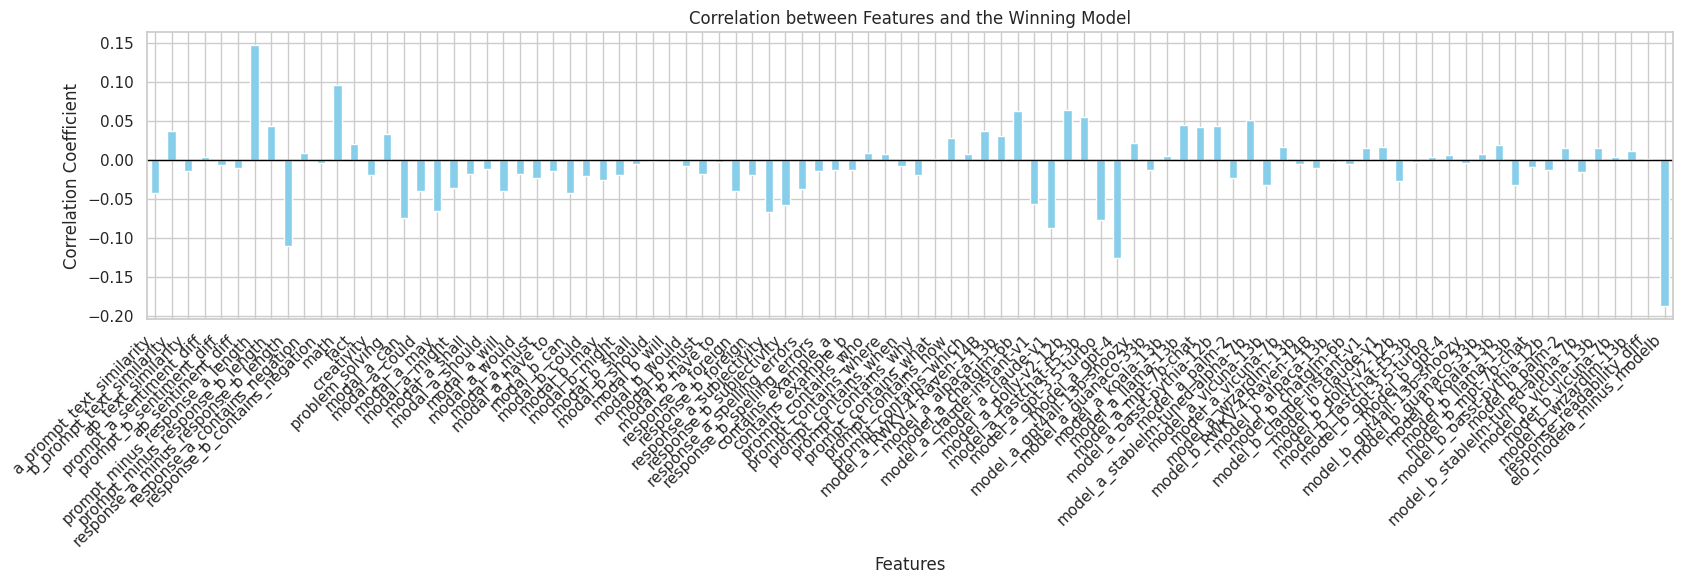

In [775]:
#Graph feature correlations with winning models

# Plot correlations (vertical bar chart)
plt.figure(figsize=(17, 6))
correlations.plot(kind='bar', color='skyblue')
plt.title("Correlation between Features and the Winning Model")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [815]:
# Define x-variable with just the features that had an absolute value of 0.05 correlation or more
# We will run the models with both sets of features to see if the other variables have a significant impact on the model's accuracy
X_reduced = filtered_df[[
                 'prompt_minus_response_b_length', 'response_a_minus_response_b_length',
                  'elo_modela_minus_modelb', 'math', 'modal_a_can', 'modal_a_may', 'model_a_claude-v1', 'model_b_claude-instant-v1', 'model_a_gpt-3.5-turbo', 'model_a_gpt-4', 'model_a_vicuna-13b']]
X_reduced_normalized = scaler.fit_transform(X_reduced)

In [240]:
# Split full feature data into 80/20 train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

In [817]:
# Split reduced feature data into 80/20 train and test sets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced_normalized, y_encoded, test_size=0.2, random_state=42)

In [780]:
# Generate random predictions of test data as a baseline
def random_predictions(x_test, y_test):
    # Randomly predict target values from y_test (not features from x_test)
    random_y_preds = np.random.choice(y_test, len(y_test), replace=True)

    return random_y_preds

# Run random model on test data
random_y_preds = random_predictions(X_test, y_test)

num_classes = len(np.unique(y_test))
random_y_scores = np.random.rand(len(y_test), num_classes)

# Binarize the true labels for multi-class AUC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))


# Calculate performance metrics for random predictions
accuracy = accuracy_score(y_test, random_y_preds)
precision = precision_score(y_test, random_y_preds, average='weighted')
recall = recall_score(y_test, random_y_preds, average='weighted')
f1 = f1_score(y_test, random_y_preds, average='weighted')
auc = roc_auc_score(y_test_binarized, random_y_scores, average='macro', multi_class='ovr')


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'AUC: {auc}')


Precision: 0.2946460965690854
Recall: 0.2969768820391227
F1-score: 0.2957661656824039
Accuracy: 0.2969768820391227
AUC: 0.49752995895945373


In [781]:

# Run a grid search for the logistic regression model to find optimal parameters

# Define the model
model = LogisticRegression(max_iter=1000)

# Define the hyperparameters grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [500, 1000, 2000]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'C': 10, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}


In [804]:
# Build the logistic regression model
model = LogisticRegression(C=10, penalty='l2', solver='liblinear', max_iter=500)

# Train the model
class_weights = {0: 1, 1: 1, 2: 1.33, 3: 1.33}
weights = np.array([class_weights[label] for label in y_train])
model.fit(X_train, y_train, sample_weight= weights)

# Run the model on test data
y_pred = model.predict(X_test)

In [805]:
# Calculate evaluation metrics on the test data
# accuracy is a little too low
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

y_prob = model.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'Multiclass ROC AUC: {auc_score}')

Precision: 0.5324393206911088
Recall: 0.5498913258249358
F1-score: 0.5254601250506721
Accuracy: 0.5498913258249358
Multiclass ROC AUC: 0.7560317420652485


In [784]:

# Run a grid search for the logistic regression model to find optimal parameters

# Define the model
model = LogisticRegression(max_iter=1000)

# Define the hyperparameters grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [500, 1000, 2000]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_r, y_train_r)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}


In [818]:
# Build the logistic regression model
model = LogisticRegression(C=0.01, penalty='l2', solver='liblinear', max_iter=500)

# Train the model on reduced x variables
weights_r = np.array([class_weights[label] for label in y_train_r])
model.fit(X_train_r, y_train_r, sample_weight= weights_r)

# Run the model on test data
y_pred_r = model.predict(X_test_r)

In [819]:
# Calculate evaluation metrics on the test data
# accuracy is lower with reduced x variables
accuracy = accuracy_score(y_test_r, y_pred_r)
precision = precision_score(y_test_r, y_pred_r, average='weighted')
recall = recall_score(y_test_r, y_pred_r, average='weighted')
f1 = f1_score(y_test_r, y_pred_r, average='weighted')

y_prob_r = model.predict_proba(X_test_r)
auc_score = roc_auc_score(y_test_r, y_prob_r, multi_class='ovr', average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'Multiclass ROC AUC: {auc_score}')

Precision: 0.4596249140259963
Recall: 0.5354672989527761
F1-score: 0.48604635775796984
Accuracy: 0.5354672989527761
Multiclass ROC AUC: 0.7253288622736473


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [787]:
#Grid search for random forest
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3],
    'class_weight': [None, 'balanced']
}

# Get all combinations of the grid
all_params = list(itertools.product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["min_samples_split"],
    param_grid["min_samples_leaf"],
    param_grid["class_weight"]
))

best_score = 0
best_params = None

# Evaluate each combination
for params in all_params:
    clf = RandomForestClassifier(
        n_estimators=params[0],
        max_depth=params[1],
        min_samples_split=params[2],
        min_samples_leaf=params[3],
        class_weight=params[4],
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("Best Parameters Found:", best_params)
print("Best Score:", best_score)


Best Parameters Found: (200, 20, 2, 1, None)
Best Score: 0.554567462081913


In [241]:
# Create a Random Forest model
clf = RandomForestClassifier(n_estimators=200, max_depth= 20, min_samples_split=2,
                            min_samples_leaf=1, max_features= 'sqrt', n_jobs=-1,
                            class_weight= None, bootstrap=True)
# Train model
clf.fit(X_train, y_train)

# Run model on Test data
y_pred_clf = clf.predict(X_test)

In [242]:
#calculate metrics for final model (RF with full features)
accuracy = accuracy_score(y_test, y_pred_clf)
precision = precision_score(y_test, y_pred_clf, average='weighted')
recall = recall_score(y_test, y_pred_clf, average='weighted')
f1 = f1_score(y_test, y_pred_clf, average='weighted')

y_prob_clf = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_prob_clf, multi_class='ovr', average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'Multiclass ROC AUC: {auc_score}')

Precision: 0.5603925704521615
Recall: 0.5605611539221498
F1-score: 0.5095770378195561
Accuracy: 0.5605611539221498
Multiclass ROC AUC: 0.7605944727118903


In [243]:
# Run model on test data
y_pred_clf = clf.predict(test_normalized)

In [244]:
#Add a column to test df with model predictions
merged_df_t['winner'] = y_pred_clf

In [245]:
#convert the classifications to integer to match up to mapping function
merged_df_t['winner'] = merged_df_t['winner'].astype(int)


In [246]:
 #map classes to their model name
 merged_df_t['winner'] = merged_df_t['winner'].map({0: 'model_a', 1: 'model_b', 2: 'tie', 3: 'tie (bothbad)'})

In [247]:
# Create a DataFrame with predictions
results_df = pd.DataFrame({
    'question_id': merged_df_t['question_id'],
    'winner' : merged_df_t['winner']

})

# Save the results to a CSV file
results_df.to_csv('model_predictions.csv', index=False)

print("Predictions saved to 'model_predictions.csv'")


Predictions saved to 'model_predictions.csv'


## Other versions of Random Forest Model (not part of final model)

In [821]:
#run random forest on reduced features set
# Train model
clf.fit(X_train_r, y_train_r)

# Run model on Test data
y_pred_clf_r = clf.predict(X_test_r)

In [822]:
# Calculate evaluation metrics for reduced x-variables
# accuracy is acceptible but lower than it is with all x-variables
accuracy_r = accuracy_score(y_test_r, y_pred_clf_r)
precision_r = precision_score(y_test_r, y_pred_clf_r, average='weighted')
recall_r = recall_score(y_test_r, y_pred_clf_r, average='weighted')
f1_r = f1_score(y_test_r, y_pred_clf_r, average='weighted')

y_prob_clf_r = clf.predict_proba(X_test_r)
auc_score_r = roc_auc_score(y_test_r, y_prob_clf_r, multi_class='ovr', average='weighted')

print(f'Precision: {precision_r}')
print(f'Recall: {recall_r}')
print(f'F1-score: {f1_r}')
print("Accuracy:", accuracy_r)
print(f'Multiclass ROC AUC: {auc_score_r}')

Precision: 0.47619694981858035
Recall: 0.5145228215767634
F1-score: 0.48232299640214393
Accuracy: 0.5145228215767634
Multiclass ROC AUC: 0.7175908389996991


In [793]:
#Try resampling to handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

clf.fit(X_train_res, y_train_res)

# Predict on the test data
y_pred = clf.predict(X_test)


In [794]:
# Calculate evaluation metrics for resampled classes
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

y_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'Multiclass ROC AUC: {auc_score}')

Precision: 0.5247304246009762
Recall: 0.5425805176842521
F1-score: 0.5308306507459764
Accuracy: 0.5425805176842521
Multiclass ROC AUC: 0.7542700254604732


In [ ]:
# Check for class imbalances
class_distribution = sentiment_df['winner'].value_counts()
print(class_distribution)

winner
model_a          9002
model_b          8862
tie (bothbad)    4632
tie              2786
Name: count, dtype: int64


<ipython-input-65-3f7ab02d3f20>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


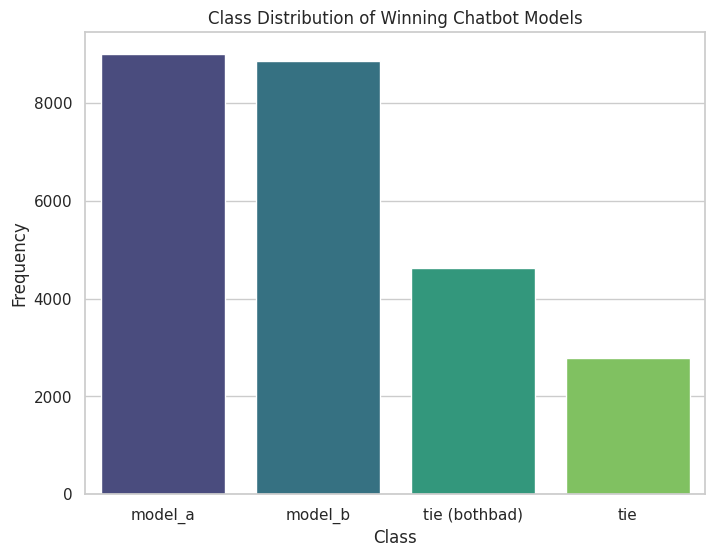

In [ ]:
# Calculate class distributions to visualize class imbalance
class_distribution = sentiment_df['winner'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution of Winning Chatbot Models')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


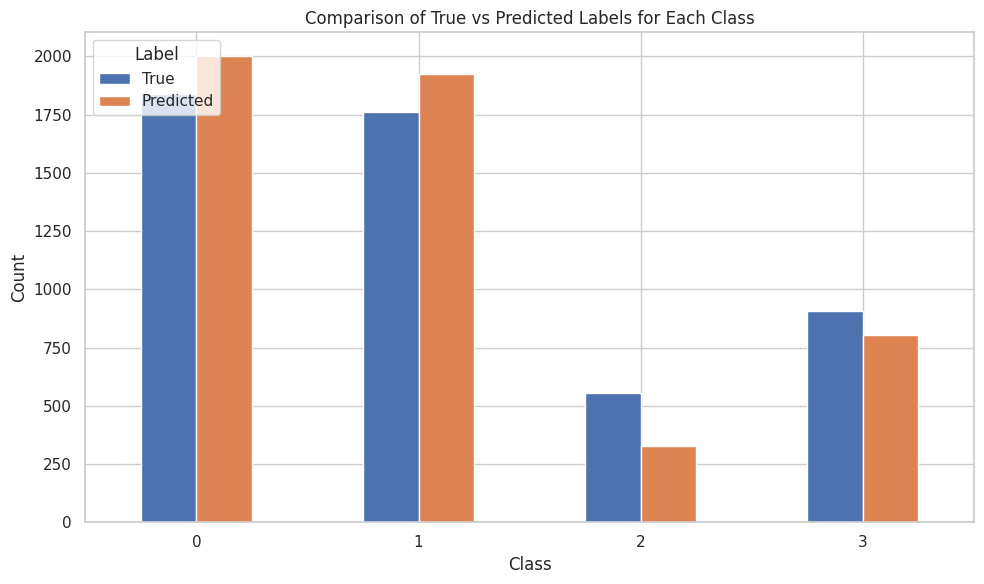

In [795]:


# count class occurences for y_test and y_pred
y_test_counts = pd.Series(y_test).value_counts().sort_index()
y_pred_counts = pd.Series(y_pred).value_counts().sort_index()

# convert to df
comparison_df = pd.DataFrame({
    'True': y_test_counts,
    'Predicted': y_pred_counts
}).fillna(0)

# plot the bar plot
comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of True vs Predicted Labels for Each Class')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(title='Label', loc='upper left')
plt.tight_layout()

plt.show()


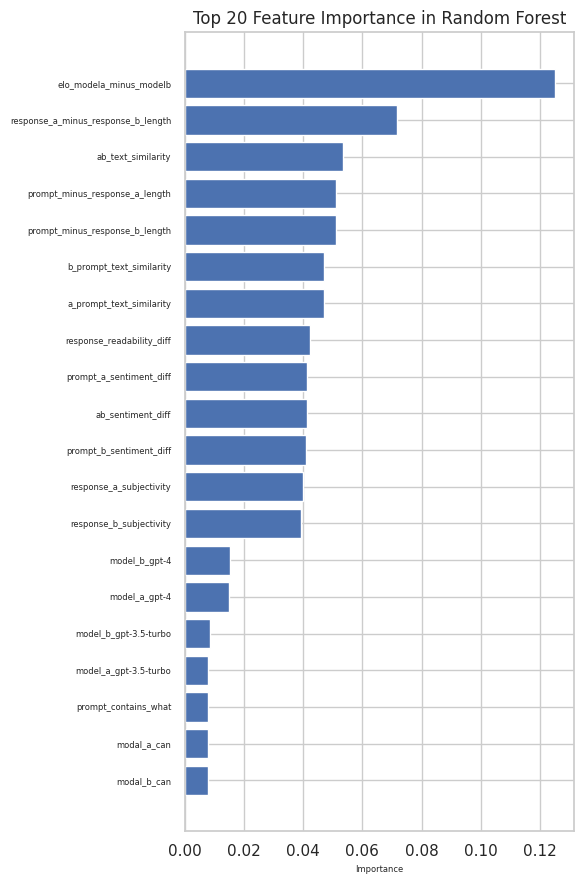

In [809]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import pandas as pd







# Get the feature importances
importances = clf.feature_importances_

# Sort the importances in descending order and get the corresponding feature indices
indices = importances.argsort()[::-1]  # Sort in descending order

# Select the top 20 features
top_n = 20
top_indices = indices[:top_n]

# Plotting the top 20 feature importances
plt.figure(figsize=(6, 9))
plt.title("Top 20 Feature Importance in Random Forest")
plt.barh(range(top_n), importances[top_indices], align="center")
plt.yticks(range(top_n), [X.columns[i] for i in top_indices], fontsize=6)  # Feature names if X is a DataFrame
plt.xlabel("Importance", fontsize=6)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.tight_layout()
plt.show()



## Merging CSV files for model and hardness score predictions

In [808]:
# Load the CSV files into DataFrames
model_predictions = pd.read_csv("model_predictions.csv")
test_predictions = pd.read_csv("test_predictions.csv")

# Merge the DataFrames on 'question_id'
merged_df = pd.merge(model_predictions, test_predictions, on="question_id", how="inner")

# Display the first few rows of the merged DataFrame
print(merged_df.head())

# Save the merged DataFrame to a new CSV file (optional)
merged_df.to_csv("merged_predictions.csv", index=False)

                        question_id   winner  hardness_score
0  a5bd0905ce184926ad6e2c8ac3516fca  model_b             8.0
1  a6173eefe0a444f69c801934f0619b2b  model_b             7.0
2  a56d44839d354d94ab674e8bd72a5ef3  model_a             8.0
3  f10215a74f974d81bce321826e0693cc  model_b             8.0
4  08003723f24740a6bdb547a10e70cad9  model_b             8.0


In [252]:
# Load the CSV files into DataFrames
model_predictions = pd.read_csv("model_predictions.csv")
test_predictions = pd.read_csv("test_predictions_b-2.csv")

In [253]:
#remove duplicate question id from hardness score
test_predictions = test_predictions.drop_duplicates(subset='question_id', keep='first')

In [256]:

# Print the number of rows in each DataFrame
print(f"Number of rows in model_predictions: {model_predictions.shape[0]}")
print(f"Number of rows in test_predictions: {test_predictions.shape[0]}")

# Merge the DataFrames on 'question_id'
merged_df = pd.merge(model_predictions, test_predictions, on="question_id", how="inner")

# Print the number of rows in the merged DataFrame
print(f"Number of rows in merged_df: {merged_df.shape[0]}")

# Display the first few rows of the merged DataFrame
print(merged_df.head())

# Save the merged DataFrame to a new CSV file
merged_df.to_csv("merged_predictions.csv", index=False)


Number of rows in model_predictions: 3200
Number of rows in test_predictions: 3199
Number of rows in merged_df: 3200
                        question_id   winner  hardness_score
0  4f332ebd8cdc4ff2be74aa8828ff20d5  model_b             6.0
1  f2be6f13e5ed40e5b81443223996494c  model_b             6.0
2  5fafefb8a0c54243afb52d2892946cea  model_b             8.0
3  7834f572267f40709ecebb273a2b346b  model_a             4.0
4  1ccc7e58290245c4bd5457fce45f8640  model_a             7.0
